# word embedding training

## loading the documents

In [19]:

import os
import csv
import spacy

class Corpus(object):

    def __init__(self, filename):
        self.filename = filename
        self.nlp = spacy.blank("en")
        
    def __iter__(self):
        with open(self.filename, "r",encoding="utf8") as i:
            reader = csv.reader(i, delimiter=",")
            for _, abstract in reader:
                tokens = [t.text.lower() for t in self.nlp(abstract)]
                yield tokens
                            
                    
documents = Corpus("arxiv/arxiv.csv")

## word to vector model by gensim
we could also use [GloVe](https://nlp.stanford.edu/projects/glove/) or [fastText](https://fasttext.cc/)

In [20]:
import gensim

model = gensim.models.Word2Vec(documents, min_count=100, window=5, vector_size=100)

example embeddings of the word"ml"

In [24]:
model.wv["ml"]

array([-0.6793895 , -1.0208957 ,  0.3952851 ,  0.03352967,  0.3292678 ,
       -0.2101714 , -0.36596134, -0.27441737, -0.19538936, -0.3726538 ,
        0.15264061, -0.67568815, -0.22904818,  0.02785958, -1.0057974 ,
        0.17476058, -0.99016   ,  0.03489673,  0.11060957, -0.20055656,
        0.76738423,  0.34831968,  0.35814735,  0.07667329, -0.3443255 ,
       -0.14889482,  0.20060799, -0.05095069,  0.22798905, -0.34153736,
        0.20123214, -0.27133107,  1.0637455 ,  0.08089982,  0.35108164,
       -0.26279348, -0.19113535, -1.0836161 , -0.3999534 ,  0.33080435,
       -0.3324108 , -1.2530618 ,  1.4714555 , -0.4279477 , -0.6821529 ,
        0.20920709, -0.08363605,  0.47087285,  0.04500043, -0.00555582,
       -0.06237901, -0.05156957, -0.4135776 , -0.64433   ,  0.22955303,
       -0.58924013, -0.13583529,  0.52771664,  0.7151998 , -0.02582182,
       -0.21312569,  0.626898  ,  0.08997534,  0.72158736, -0.26197338,
       -0.10236868, -0.03160806, -0.01957604,  0.12345535,  0.41

similarity function based on the cosine function

In [25]:
print(model.wv.similarity("nmt", "smt"))

0.6455282


top 10 most similar words to "bert" 

In [26]:
model.wv.similar_by_word("bert", topn=10)

[('roberta', 0.7980250120162964),
 ('transformer', 0.7800360321998596),
 ('transformers', 0.7121948599815369),
 ('mbert', 0.6926144361495972),
 ('elmo', 0.6914080381393433),
 ('pretrained', 0.6801584959030151),
 ('gpt-2', 0.6659343838691711),
 ('xlm', 0.6474730968475342),
 ('xlnet', 0.6446148753166199),
 ('lstm', 0.610761284828186)]

words that are similar to certain words but dissimilar to others

In [27]:
model.wv.most_similar(positive=["transformer", "lstm"], negative=["bert"], topn=1)

[('rnn', 0.8278220295906067)]

find the odd one out

In [28]:
print(model.wv.doesnt_match("lstm cnn gru svm transformer".split()))

svm


## ploting the embeddings

T-SNE, short for t-distributed Stochastic Neighbor Embedding,<br>
helps us visualize high-dimensional data by mapping similar data to nearby points and dissimilar data to distance points in the low-dimensional space.<br>
in other words mapping our 100 dim embeddings to 2 dim values.<br>
T-SNE is present in Scikit-learn.<br>
To run it, we just have to specify the number of dimensions we'd like to map the data to (n_components),<br>
and the similarity metric that t-SNE should use to compute the similarity between two data points (metric).<br>
We're going to map to 2 dimensions and use the cosine as our similarity metric.<br>
Additionally, we use PCA as an initialization method to remove some noise and speed up computation.<br>

In [30]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

target_word = "bert"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)] + [target_word]
embeddings = [model.wv[w] for w in selected_words] + model.wv["bert"]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

C:\Users\newgh\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\newgh\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

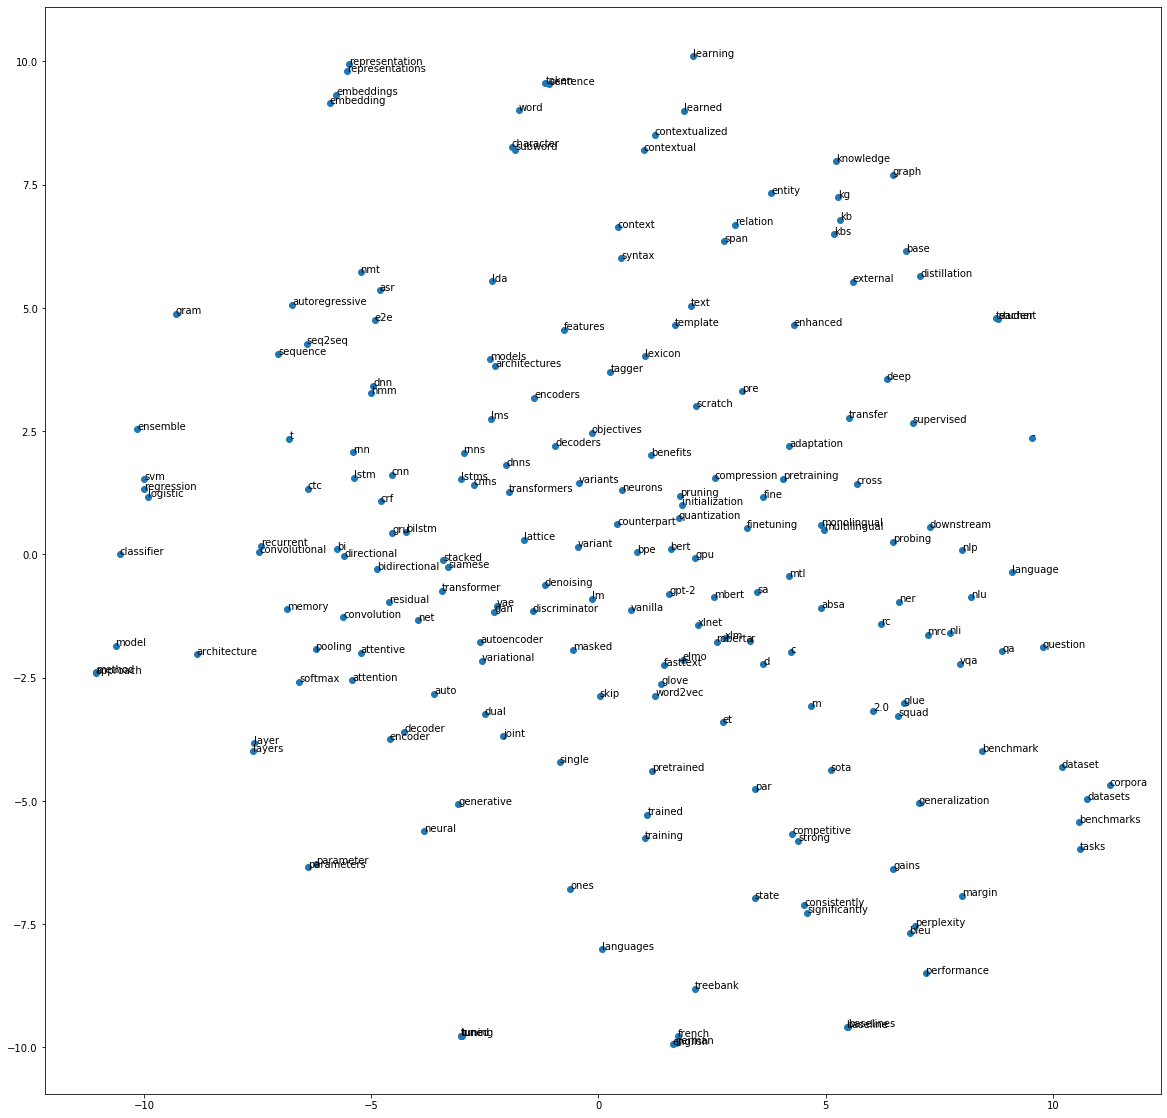

In [31]:
plt.figure(figsize=(20,20))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

## model evaluation

we expect a noun to have another noun as nearest neighbour, and the same for verbs ... <br>
so We'll count how many times two nearest neighbours in the vector space have the same part of speech.

In [34]:
from tqdm.notebook import tqdm

# we load the small english model from spacy
spacyModel = spacy.load("en_core_web_sm")

# the list to map a word to its position in a sentence noun, verb ....
word2pos = {}

for word in tqdm(model.wv.key_to_index):
    word2pos[word] = spacyModel(word)[0].pos_

word2pos["translation"]

C:\Users\newgh\Anaconda3\lib\site-packages\spacy\util.py:1636: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


  0%|          | 0/3099 [00:00<?, ?it/s]

'NOUN'

Then we write a simple method that takes a model and looks up the nearest neighbour to every word in its vocabulary. <br>
It returns the number of times this nearest neighbour has the same part of speech: a percentage we'll call the accuracy.

In [35]:
import numpy as np

def evaluate(model, word2pos):
    same = 0
    for word in tqdm(model.wv.key_to_index):
        most_similar = model.wv.similar_by_word(word, topn=1)[0][0]
        if word2pos[most_similar] == word2pos[word]:
            same += 1
    return same/len(model.wv.key_to_index)
       
evaluate(model, word2pos)

  0%|          | 0/3099 [00:00<?, ?it/s]

0.6508551145530816

## hyperparameter exploration 

we're interested in the influence of embedding size and the size of the context window. 

In [37]:
sizes = [100, 200, 300]
windows = [2,5,10]

df = pd.DataFrame(index=windows, columns=sizes,dtype = object)

for size in sizes:
    for window in windows:
        print("Size:", size, "Window:", window)
        model = gensim.models.Word2Vec(documents, min_count=100, window=window, vector_size=size)
        acc = evaluate(model, word2pos)
        df[size][window] = acc
        
df

Size: 100 Window: 2


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 100 Window: 5


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 100 Window: 10


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 200 Window: 2


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 200 Window: 5


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 200 Window: 10


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 300 Window: 2


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 300 Window: 5


  0%|          | 0/3099 [00:00<?, ?it/s]

Size: 300 Window: 10


  0%|          | 0/3099 [00:00<?, ?it/s]

,100,200,300
2,0.682801,0.679251,0.67667
5,0.650532,0.649887,0.649564
10,0.616651,0.613101,0.619555


Although the accuracies of all models are very similar, the results do show some interesting patterns.<br>

First, it looks like smaller contexts work better than larger ones. This is logical, as our evaluation metric is a syntactic one: the closest context words contain much more useful information about the part of speech of a word than those further away.<br>

Second, higher-dimensional word embeddings do not necessarily work better than lower-dimensional ones. This may sound counter-intuitive, as higher-dimensional embeddings are able to capture more information. Still, larger embeddings also require more data, while we're using a pretty small corpus.